# JPL-NISAR Radar Short Course HW10
Elizabeth Wig
November 1, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Howard's function to display visually appealing interferograms
def dismph(image, nr, naz): # Function takes complex image, size in range and azimuth 
    upramp = np.linspace(100,255,120)/255
    dnramp = np.linspace(255,100,120)/255
    oneramp = np.ones(120)
    zeroramp = np.zeros(120)
    r = np.zeros(360)
    g = np.zeros(360)
    b = np.zeros(360)
    r[0:120]=upramp; r[120:240]=oneramp; r[240:360]=dnramp
    g[0:120]=dnramp; g[120:240]=upramp; g[240:360]=oneramp
    b[0:120]=oneramp; b[120:240]=dnramp; b[240:360]=upramp

    fig = plt.figure(figsize=(10, 10))
    phase = np.angle(image)*180./np.pi

    exponent=0.3
    scale = 1
    mag=np.power(np.absolute(image),exponent)
    ampsum=sum(sum(mag))
    ampi=naz*nr
    ampi=np.count_nonzero(mag)
    scalemag = (scale*150/(ampsum/ampi))/256

    mag = np.clip(mag*scalemag,0,1)

    icolor = phase.astype(int)
    icolor = np.where(icolor < 0, icolor+360, icolor)
    icolor = icolor.clip(max=359)

    # load color table values for image
    rgb = np.zeros((nr,naz,3))
    rgb[:,:,0] = r[icolor[:,:]]*mag
    rgb[:,:,1] = g[icolor[:,:]]*mag
    rgb[:,:,2] = b[icolor[:,:]]*mag

    plt.imshow(rgb)

In [3]:
def multilook16x4(image,width, nlines): # Function to take 16 x 4 looks
    # There are many ways to do this: you can convolve with a rectangle and downsample
    # You can say for, e.g. two looks, img_ml_2 = (img[0::2] + img[1::2])/2
    # This method reshapes the image so that all the pixels within a multilook window
    # are elements in a 3rd dimension, and then finds the mean across that dimension.
    img_temp = np.sum(np.reshape(image, ( width//4,4, nlines)), axis=1)    
    ml_img = np.sum(np.reshape(img_temp.T, (nlines//16,16, width//4)), axis=1)
    ml_img = ml_img.T /4/16
    return ml_img

# P1a: Read in the files and display interferogram

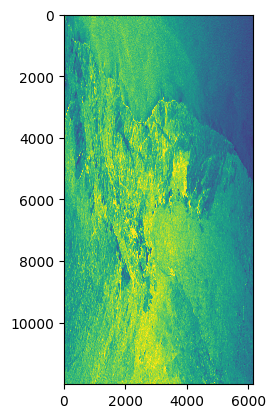

In [4]:
filepath = "/Users/elizabethwig/Library/CloudStorage/OneDrive-Stanford/Stanford_NonResearch/JPL-NISAR Radar Course/Day 09 Interferometry/HW9"
slc1path = filepath+"/slc1.dat"
slc2path = filepath+"/slc2.dat"

nr = 6144      # Number of range bins
naz = 12000    # Number of azimuth bins

# file = open(slc1path,"rb")
slc1cpx = np.fromfile(slc1path,dtype=np.float32) # Read in file as float32
slc1vec = slc1cpx[0::2] + 1j * slc1cpx[1::2]     # Convert to complex numbers
slc1 = np.reshape(slc1vec,(naz,nr))              # Reshape to proper size
slc2cpx = np.fromfile(slc2path,dtype=np.float32) # Read in file as float32
slc2vec = slc2cpx[0::2] + 1j * slc2cpx[1::2]     # Convert to complex numbers
slc2 = np.reshape(slc2vec,(naz,nr))              # Reshape to proper size

plt.imshow(np.abs(slc1)) # Display single-look complex image
plt.clim(0,300) # Color limits so image shows up clearly

In [5]:
igram = (slc1 * np.conj(slc2)).T # Cross multiply the single-look complex to get interferogram
igram_ml = multilook16x4(igram,nr,naz) # Multilook interferogram

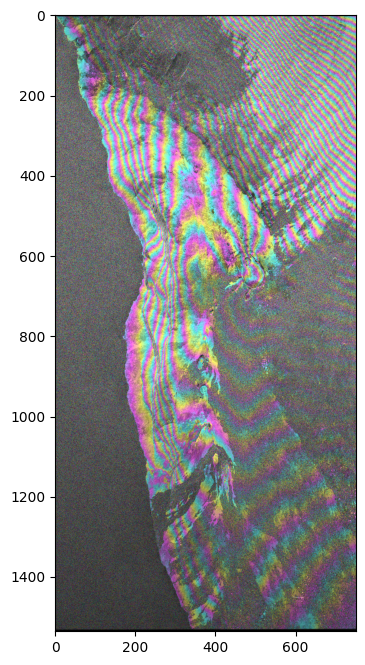

In [13]:
dismph(igram_ml, nr//4, naz//16)  # Use Howard's code to display multilooked interferogram

# P2: Load DEM and Baseline files

In [7]:
demfile = filepath+"/slc.dem" 
dem = np.fromfile(demfile,dtype=np.float32)  # Read DEM. Elevation data is not complex
dem = np.reshape(dem,(naz,nr)).T   # Reshape DEM to be size of image

dem_ml = multilook16x4(dem,nr,naz) # Multilook DEM

plt.imshow(dem_ml) 
plt.colorbar()

In [8]:
baselinefile = filepath+"/slc.baseline" 
baselines = np.loadtxt(baselinefile)     # Load baseline file
By = baselines[:,1]    # Find baseline y component
Bz = baselines[:,2]    # Find baseline z component

# P3: Calculate Difference in Path Length from Topography



# Use geometry from the
# following image: 


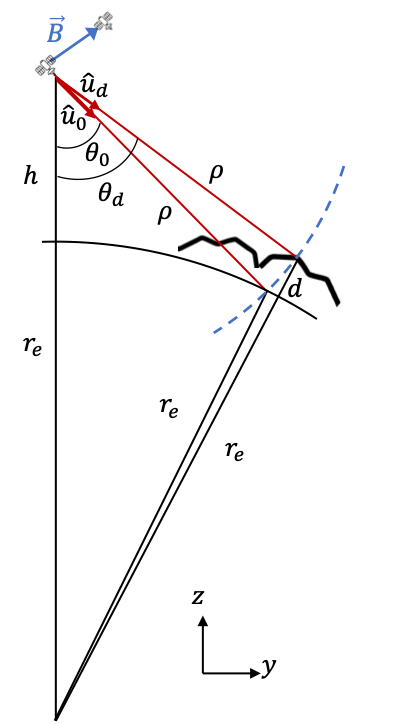

In [9]:
# Define radar parameters

r_e = 6343837.1345648393 # radius of earth (m)
h = 700000 # altitude of the satellite (m)
r0 = 741489 # range to first pixel (m)
fs = 32e6 # range sampling frequency (Hz)
lam = 0.236057 # wavelength of system (m)
c = 2.99792458e8 # speed of light (m/s)
Delta_r_bin_slant = c/(2*fs) # Slant range bin spacing

In [10]:
# First, find ranges rho 
rho = np.arange(r0, r0+(nr-1)*Delta_r_bin_slant, Delta_r_bin_slant)
rho = np.expand_dims(rho, axis=-1) # Expand dimensions of rho so it can broadcast with 2D DEM
# Then, project the baseline vector in the direction of the look angle
theta0  = np.arccos(((r_e+h)**2 + rho**2 - r_e**2)/(2*(r_e+h)*rho));
thetad = np.arccos(((r_e+h)**2 + rho**2 - (r_e+dem)**2)/(2*(r_e+h)*rho));
# Use trigonometry to find unit vectors along rho
u0_y = np.sin(theta0);
u0_z = np.cos(theta0);
ud_y = np.sin(thetad);
ud_z = np.cos(thetad);
# Project baselines onto unit vectors at each pixel
proj_B0 = (By*u0_y + Bz*u0_z);
proj_Bd = (By*ud_y + Bz*ud_z);

In [11]:
# Calculate topo phase. This is accurate, though not constrained between 0 and 2pi
# So you can think of it as "not wrapped"
topo_phase = (proj_Bd-proj_B0)*-4*np.pi/lam;
# Find the signal used to correct for the topo phase
topo_signal = np.exp(-1j*topo_phase)
# Multilook the topo signal
ml_topo_signal = multilook16x4(topo_signal,nr,naz);

# Display the phase due to the topography 
dismph(ml_topo_signal,nr//4,naz//16)

In [12]:
# Calculate topo-corrected interferogram -- phase only from deformation
deformation_int = igram_ml * np.conj(ml_topo_signal);

# Display phase due to deformation
dismph(deformation_int, nr//4, naz//16)